# Austin Bike Share Trips


Bike shares are becoming a popular alternative means of transportation. This data includes information on bike trip start location, stop location, duration, type of bike share user. Bike station location data is also provided.

Objectives:

- What are the most common places passengers were picking up as well as dropping off? 

- How would you find the busiest time period (days of the month, time intervals) when bikers shared more bikes?

- Represent a technique that describes the area where most pickups occurred throughout the time.

- Make the date predictions for the following 10 trips.

- Verify model MAE using Cross-Validation, Pipeline and XGBoost Regression.

### Import libraries and datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # visualization

#!pip install geopandas
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import Image

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#austin_bikeshare_trips dataset

bike_file_path = '../input/austin-bike/austin_bikeshare_trips.csv'
bike_data = pd.read_csv(bike_file_path)

#austin_bikeshare_stations dataset

station_file_path = '../input/austin-bike/austin_bikeshare_stations.csv'
station_data = pd.read_csv(station_file_path)

#creates copies of the dataframes

cbd = bike_data.copy()
csd = station_data.copy()

In [4]:
cbd

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,2571.0,Red River & 8th Street,7.0,2544.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0
649227,104.0,17:20:44,53,2499.0,City Hall / Lavaca & 2nd,2.0,3619.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0
649228,240.0,13:12:55,44,2495.0,4th & Congress,11.0,2495.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0
649229,421.0,14:45:34,106,2494.0,2nd & Congress,5.0,2494.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0


In [5]:
csd

,latitude,location,longitude,name,station_id,status
0,30.27041,(30.27041 -97.75046),-97.75046,West & 6th St.,2537,active
1,30.26452,(30.26452 -97.7712),-97.77120,Barton Springs Pool,2572,active
2,30.27595,(30.27595 -97.74739),-97.74739,ACC - Rio Grande & 12th,2545,closed
3,30.28480,(30.2848 -97.72756),-97.72756,Red River & LBJ Library,1004,closed
4,30.26694,(30.26694 -97.74939),-97.74939,Nueces @ 3rd,1008,moved
...,...,...,...,...,...,...
67,30.26634,(30.26634 -97.74378),-97.74378,4th & Congress,2495,active
68,30.26780,(30.2678 -97.75189),-97.75189,3rd & West,2552,active
69,30.26960,(30.2696 -97.75332),-97.75332,5th & Bowie,2501,active
70,30.26416,(30.26416 -97.73289),-97.73289,5th & San Marcos,2564,moved


In [6]:
cbd.dtypes

bikeid                float64
checkout_time          object
duration_minutes        int64
end_station_id        float64
end_station_name       object
month                 float64
start_station_id      float64
start_station_name     object
start_time             object
subscriber_type        object
trip_id                 int64
year                  float64
dtype: object

In [7]:
print("Columns with Number of Missing Entries(bike_data):")
print("\n")
print(cbd.isnull().sum())
print("\n")
print("\n")
print("Columns with Number of Missing Entries(station_data):")
print("\n")
print(csd.isnull().sum())

Columns with Number of Missing Entries(bike_data):


bikeid                  723
checkout_time             0
duration_minutes          0
end_station_id        19842
end_station_name          0
month                 30752
start_station_id      19041
start_station_name        0
start_time                0
subscriber_type        2077
trip_id                   0
year                  30752
dtype: int64




Columns with Number of Missing Entries(station_data):


latitude      0
location      0
longitude     0
name          0
station_id    0
status        0
dtype: int64


### Extracting Date
Here we will extract the date from the time stamp of the start_time column for further visual and predictive uses.

In [8]:
x = 0
Date=[]
while x<len(cbd):
    Date.append(cbd.start_time[x][8:10])
    x = x+1

In [9]:
cbd['date'] = Date
cbd["date"] = cbd["date"].astype('int8')
cbd

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year,date
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,19
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,30
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,11
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,23
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,2571.0,Red River & 8th Street,7.0,2544.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0,6
649227,104.0,17:20:44,53,2499.0,City Hall / Lavaca & 2nd,2.0,3619.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0,6
649228,240.0,13:12:55,44,2495.0,4th & Congress,11.0,2495.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0,18
649229,421.0,14:45:34,106,2494.0,2nd & Congress,5.0,2494.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0,29


### Cleaning Up Missing Data
Here we will drop the end and start IDs and encode them using the names since these columns do not have missing data. this will create ID columns with zero missing data. We also drop rows with missing month entries by looking at the dataset containing finite values in the column. This will drop the rows with missing year entries (due to them being the rows identical to those with missing month values).

In [10]:
#dropping start/end IDs
#Since there are no missing start/end names, will encode those to fill previously missing IDs

del cbd['end_station_id']
del cbd['start_station_id']

cbd = cbd[np.isfinite(cbd['month'])]
cbd

,bikeid,checkout_time,duration_minutes,end_station_name,month,start_station_name,start_time,subscriber_type,trip_id,year,date
0,8.0,19:12:00,41,Trinity & 6th Street,3.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,19
1,141.0,2:06:04,6,South Congress & Academy,10.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,30
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,3.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,11
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,11.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,23
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,4.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,16
...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,Red River & 8th Street,7.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0,6
649227,104.0,17:20:44,53,City Hall / Lavaca & 2nd,2.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0,6
649228,240.0,13:12:55,44,4th & Congress,11.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0,18
649229,421.0,14:45:34,106,2nd & Congress,5.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0,29


In [11]:
for category in cbd:
    cbd[category]=cbd[category].astype('category')
cbd.dtypes

bikeid                category
checkout_time         category
duration_minutes      category
end_station_name      category
month                 category
start_station_name    category
start_time            category
subscriber_type       category
trip_id               category
year                  category
date                  category
dtype: object

We encode the station as well as subscriber information to obtain new ID codes.

In [12]:
cbd["start_code"] = cbd["start_station_name"].cat.codes
cbd["end_code"] = cbd["end_station_name"].cat.codes
cbd["sub_code"] = cbd["subscriber_type"].cat.codes
print(cbd.isnull().sum())

bikeid                 723
checkout_time            0
duration_minutes         0
end_station_name         0
month                    0
start_station_name       0
start_time               0
subscriber_type       2077
trip_id                  0
year                     0
date                     0
start_code               0
end_code                 0
sub_code                 0
dtype: int64


We now drop the remaining 0.4% of data with missing values to have a nice clean dataset.

In [13]:
#drops .4%

cbd = cbd.dropna(axis = 0)

In [14]:
cbd

,bikeid,checkout_time,duration_minutes,end_station_name,month,start_station_name,start_time,subscriber_type,trip_id,year,date,start_code,end_code,sub_code
0,8.0,19:12:00,41,Trinity & 6th Street,3.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,19,82,82,48
1,141.0,2:06:04,6,South Congress & Academy,10.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,30,3,73,35
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,3.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,11,20,25,35
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,11.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,23,22,81,0
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,4.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,16,60,50,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,Red River & 8th Street,7.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0,6,34,64,0
649227,104.0,17:20:44,53,City Hall / Lavaca & 2nd,2.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0,6,8,23,48
649228,240.0,13:12:55,44,4th & Congress,11.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0,18,5,5,48
649229,421.0,14:45:34,106,2nd & Congress,5.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0,29,3,3,47


### Extracting Hour
We extract the hours from checkout_time for our use in later visuals.

In [15]:
cbd.checkout_time

#for time in cbd.checkout_time:

time_list = [time[:2] for time in cbd.checkout_time]

In [16]:
#time_list

In [17]:
new_times = [time.replace(":","") for time in time_list]

In [18]:
#new_times

In [19]:
counted_times = Counter(new_times)
counted_times.most_common()

[('16', 54121),
 ('17', 54095),
 ('13', 53985),
 ('15', 53881),
 ('14', 53128),
 ('12', 49041),
 ('18', 45184),
 ('11', 40075),
 ('19', 34603),
 ('10', 29699),
 ('20', 25434),
 ('9', 24130),
 ('21', 20291),
 ('8', 19657),
 ('22', 15194),
 ('23', 9916),
 ('7', 9849),
 ('0', 7340),
 ('2', 5221),
 ('1', 5133),
 ('6', 3012),
 ('3', 1113),
 ('5', 874),
 ('4', 703)]

In [20]:
cbd["start_hour"] = new_times
cbd

,bikeid,checkout_time,duration_minutes,end_station_name,month,start_station_name,start_time,subscriber_type,trip_id,year,date,start_code,end_code,sub_code,start_hour
0,8.0,19:12:00,41,Trinity & 6th Street,3.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,19,82,82,48,19
1,141.0,2:06:04,6,South Congress & Academy,10.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,30,3,73,35,2
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,3.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,11,20,25,35,16
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,11.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,23,22,81,0,15
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,4.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,16,60,50,48,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,Red River & 8th Street,7.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0,6,34,64,0,0
649227,104.0,17:20:44,53,City Hall / Lavaca & 2nd,2.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0,6,8,23,48,17
649228,240.0,13:12:55,44,4th & Congress,11.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0,18,5,5,48,13
649229,421.0,14:45:34,106,2nd & Congress,5.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0,29,3,3,47,14


We make a column for months using their respective name, rather than number value for later visuals.

In [21]:
cbd['month_name'] = cbd['month'].astype('str')
cbd['month_name'] = cbd['month_name'].map({'1.0':'January','2.0':'February','3.0':'March','4.0':'April','5.0':'May','6.0':'June',
                                           '7.0':'July','8.0':'August','9.0':'September','10.0':'October','11.0':'November','12.0':'December'})
cbd.month_name

0            March
1          October
2            March
3         November
4            April
            ...   
649226        July
649227    February
649228    November
649229         May
649230    December
Name: month_name, Length: 615679, dtype: object

In [22]:
cbd = cbd[['bikeid','trip_id','start_station_name','end_station_name','start_time','checkout_time','start_hour',
           'date','month','month_name','year','subscriber_type','duration_minutes','start_code','end_code','sub_code']]
cbd.head()

,bikeid,trip_id,start_station_name,end_station_name,start_time,checkout_time,start_hour,date,month,month_name,year,subscriber_type,duration_minutes,start_code,end_code,sub_code
0,8.0,9900082882,Waller & 6th St.,Trinity & 6th Street,2015-03-19 19:12:00,19:12:00,19,19,3.0,March,2015.0,Walk Up,41,82,82,48
1,141.0,12617682,2nd & Congress,South Congress & Academy,2016-10-30 02:06:04,2:06:04,2,30,10.0,October,2016.0,Local365,6,3,73,35
2,578.0,9075366,Bullock Museum @ Congress & MLK,Convention Center / 4th St. @ MetroRail,2016-03-11 16:28:27,16:28:27,16,11,3.0,March,2016.0,Local365,13,20,25,35
3,555.0,9900319298,Capitol Station / Congress & 11th,Toomey Rd @ South Lamar,2014-11-23 15:12:00,15:12:00,15,23,11.0,November,2014.0,24-Hour Kiosk (Austin B-cycle),80,22,81,0
4,86.0,14468597,Rainey St @ Cummings,MoPac Pedestrian Bridge @ Veterans Drive,2017-04-16 15:39:13,15:39:13,15,16,4.0,April,2017.0,Walk Up,25,60,50,48


## What are the most common places passengers were picking up as well as dropping off?


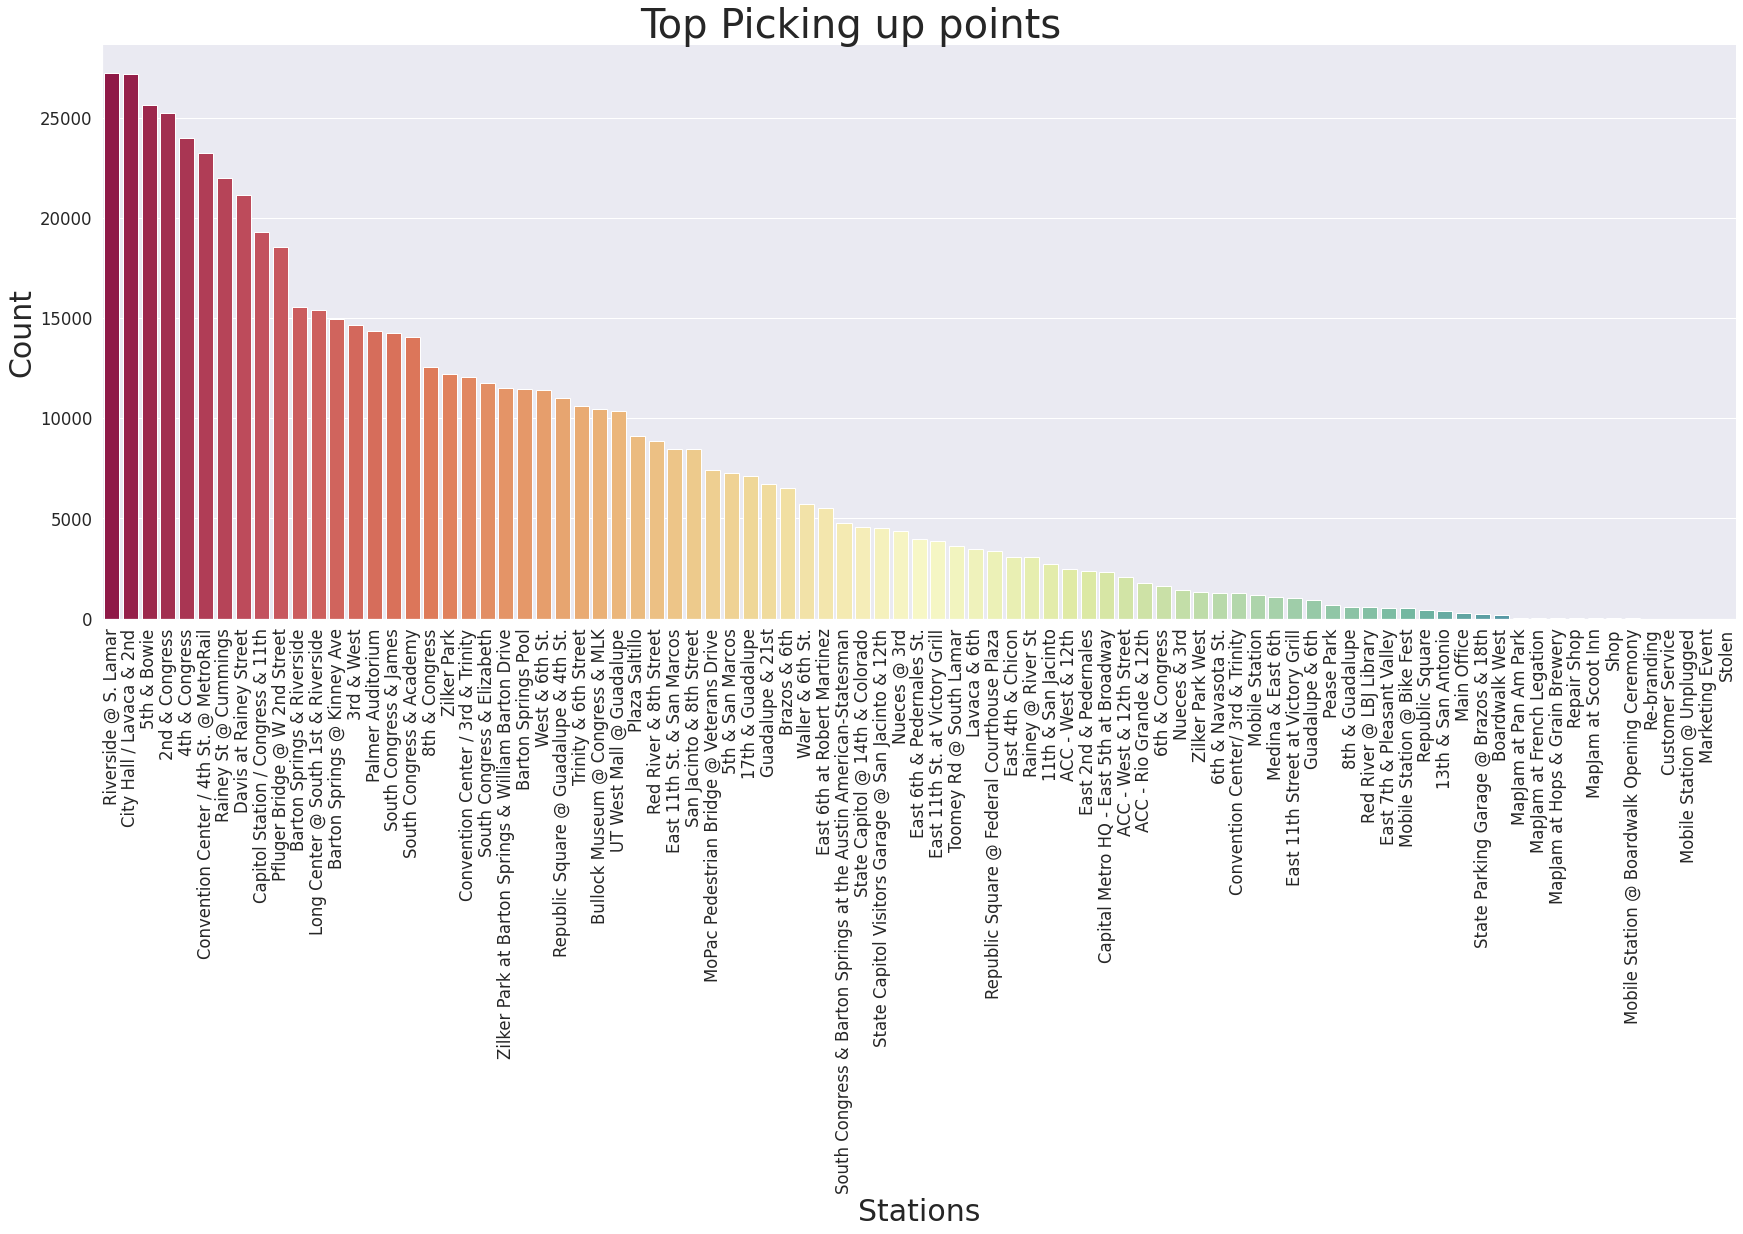

In [23]:
sns.set(font_scale = 1.5)
g=sns.catplot(x="start_station_name",kind="count", palette="Spectral",data = cbd,order=pd.value_counts(cbd['start_station_name']).iloc[:100].index)
g.set_xticklabels(rotation=90)

g.fig.set_size_inches(30,10)
g.fig.suptitle('Top Picking up points', fontsize=40)
plt.ylabel("Count", fontsize = 30)
plt.xlabel("Stations", fontsize = 30)

plt.show()

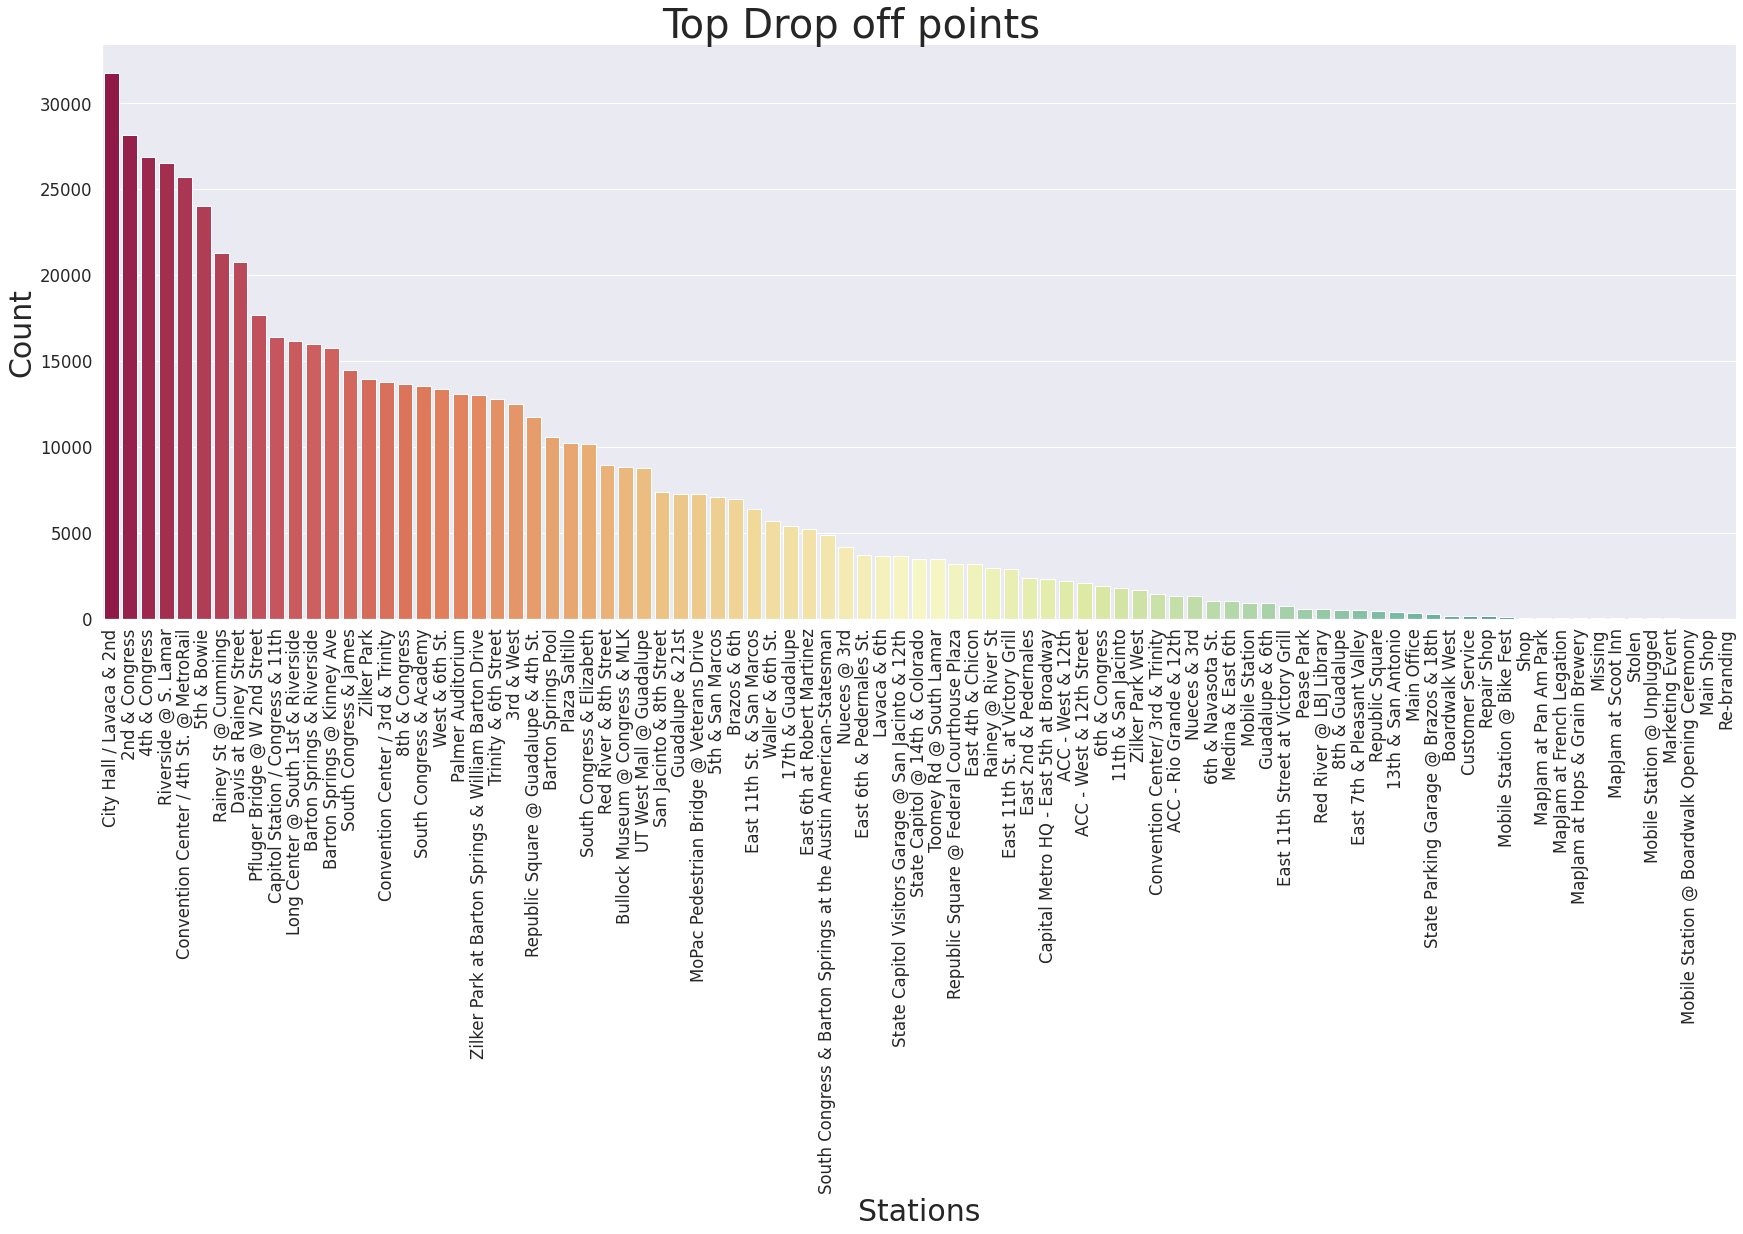

In [24]:
sns.set(font_scale = 1.5)
g=sns.catplot(x="end_station_name",kind="count", palette="Spectral",data = cbd,order=pd.value_counts(cbd['end_station_name']).iloc[:100].index)
g.set_xticklabels(rotation=90)

g.fig.set_size_inches(30,10)
g.fig.suptitle('Top Drop off points', fontsize=40)
plt.ylabel("Count", fontsize = 30)
plt.xlabel("Stations", fontsize = 30)

plt.show()

## How would you find the busiest time period (days of the month, time intervals) when bikers shared more bikes?

In [25]:
list_of_months = ['January','February','March','April','May','June',
                  'July','August','September','October','November','December']

In [26]:
index = 0
data1=pd.DataFrame()
data2=pd.DataFrame()
data3=pd.DataFrame()
data4=pd.DataFrame()
data5=pd.DataFrame()
data6=pd.DataFrame()
data7=pd.DataFrame()
data8=pd.DataFrame()
data9=pd.DataFrame()
data10=pd.DataFrame()
data11=pd.DataFrame()
data12=pd.DataFrame()
data13=pd.DataFrame()
dfs = [data1,data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13]

while index < len(dfs):
    dfs[index] = cbd[cbd['month'] == index]
    index = index + 1

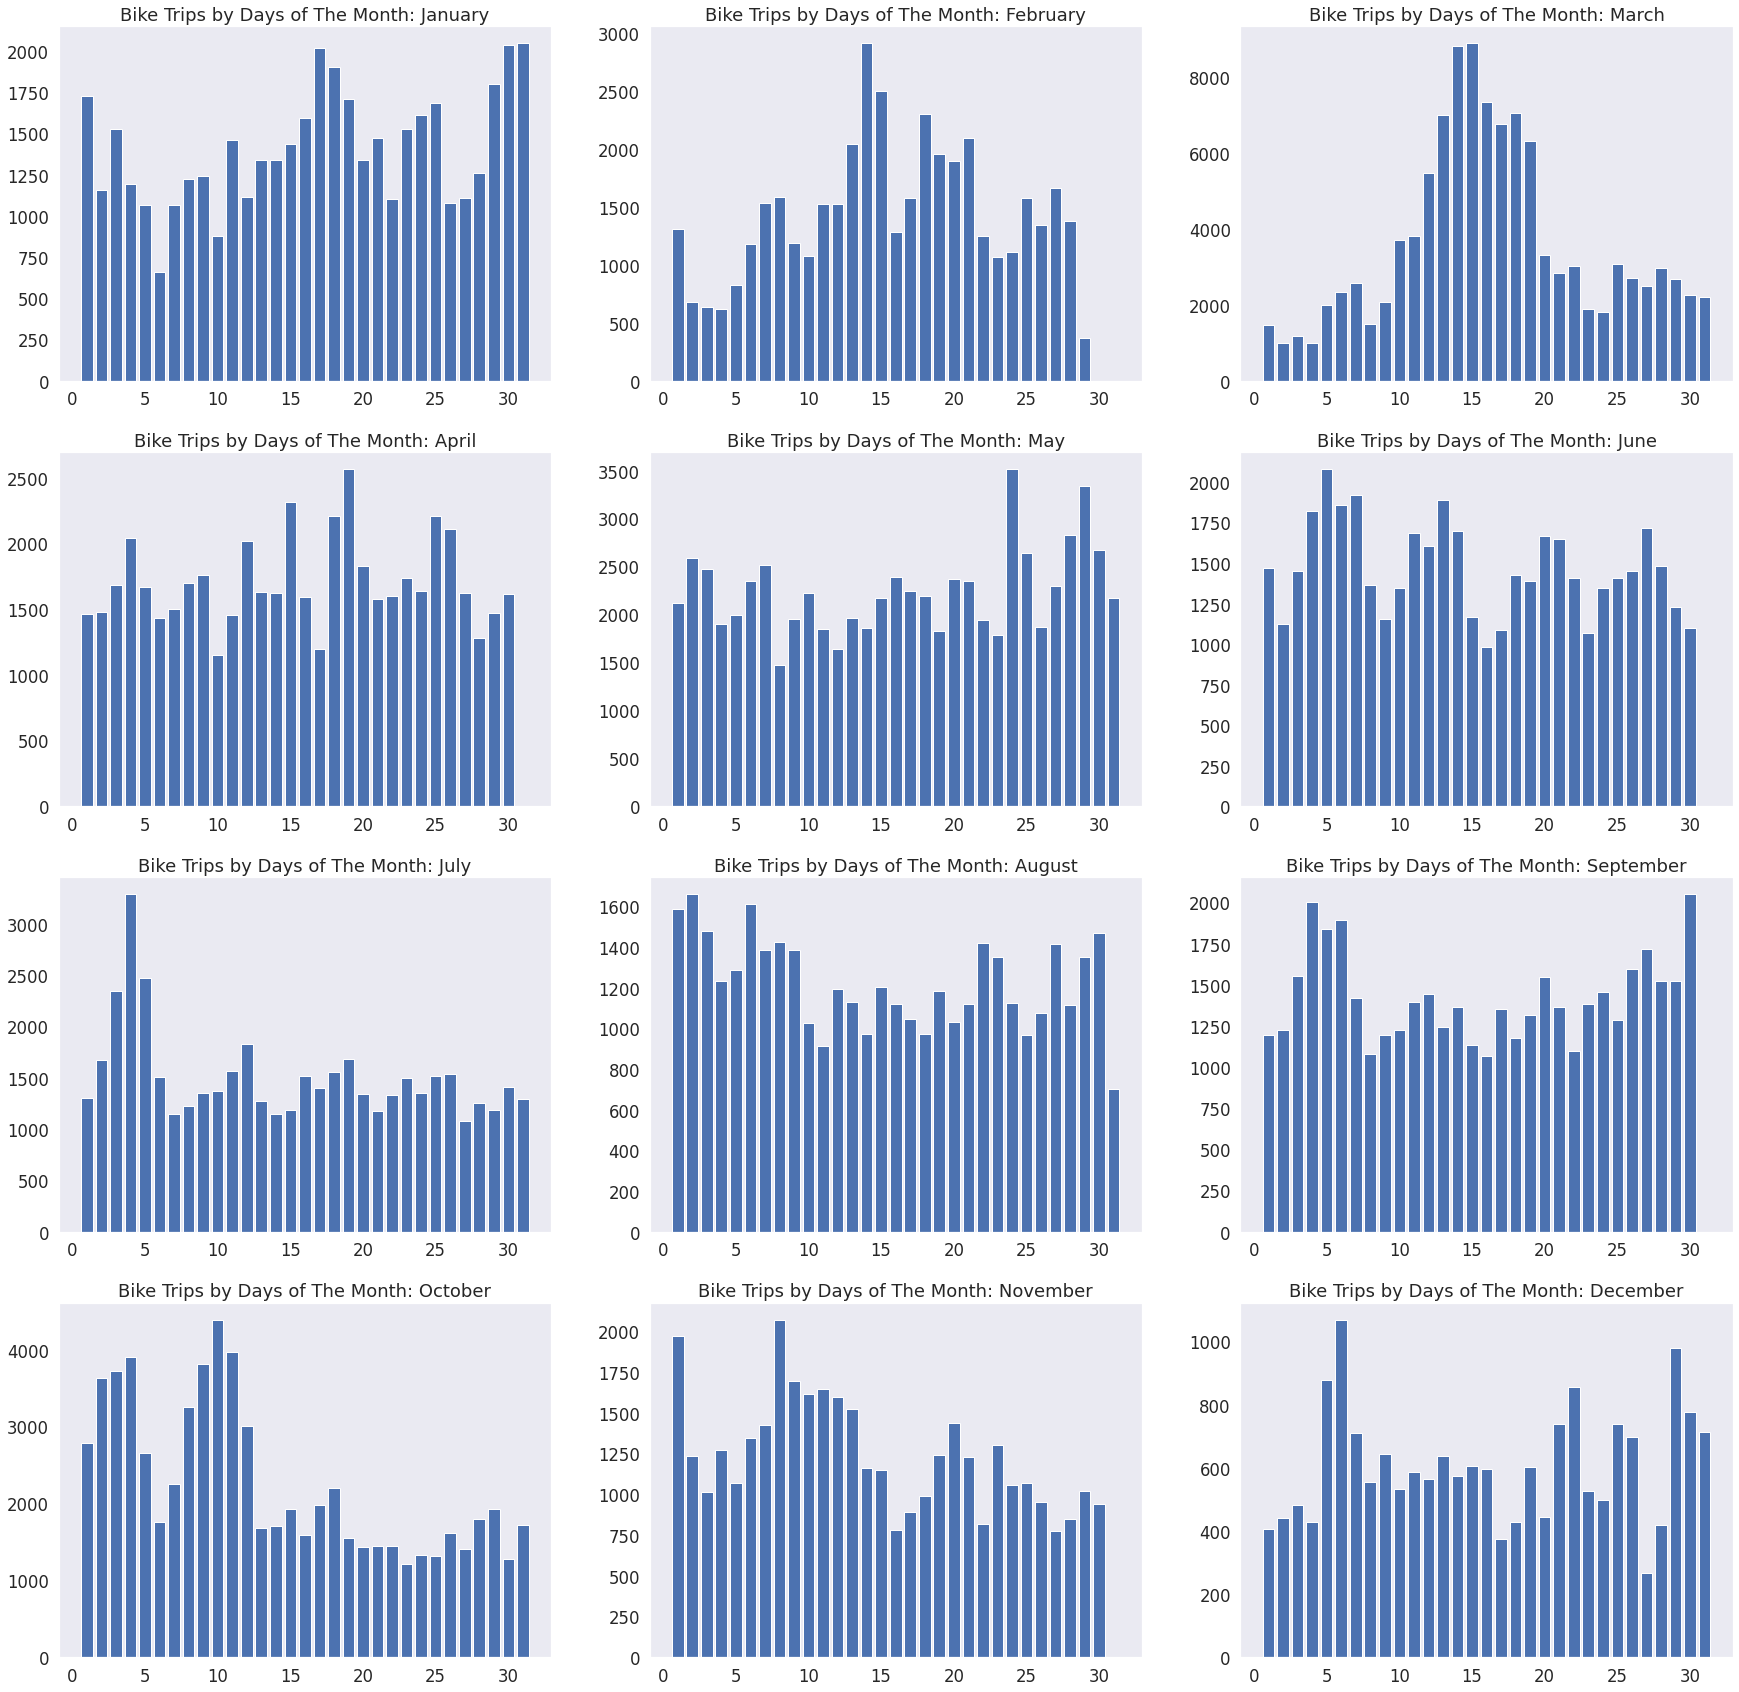

In [27]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=4, 
                         ncols=3, 
                         figsize=(30,30),
                         )
index2 = 0
index = 1
row = 0
col = 0
while( index<len(dfs)):
    y = dfs[index]['date'].value_counts()
    
    
    x = y.index
    
    axes[row,col].bar(x,y)
    axes[row,col].set_title('Bike Trips by Days of The Month: ' + list_of_months[index2])
    index = index + 1
    index2 = index2 +1
    if col == 2:
        col = 0
        row = row + 1
        
    elif col != 2:
        col = col + 1

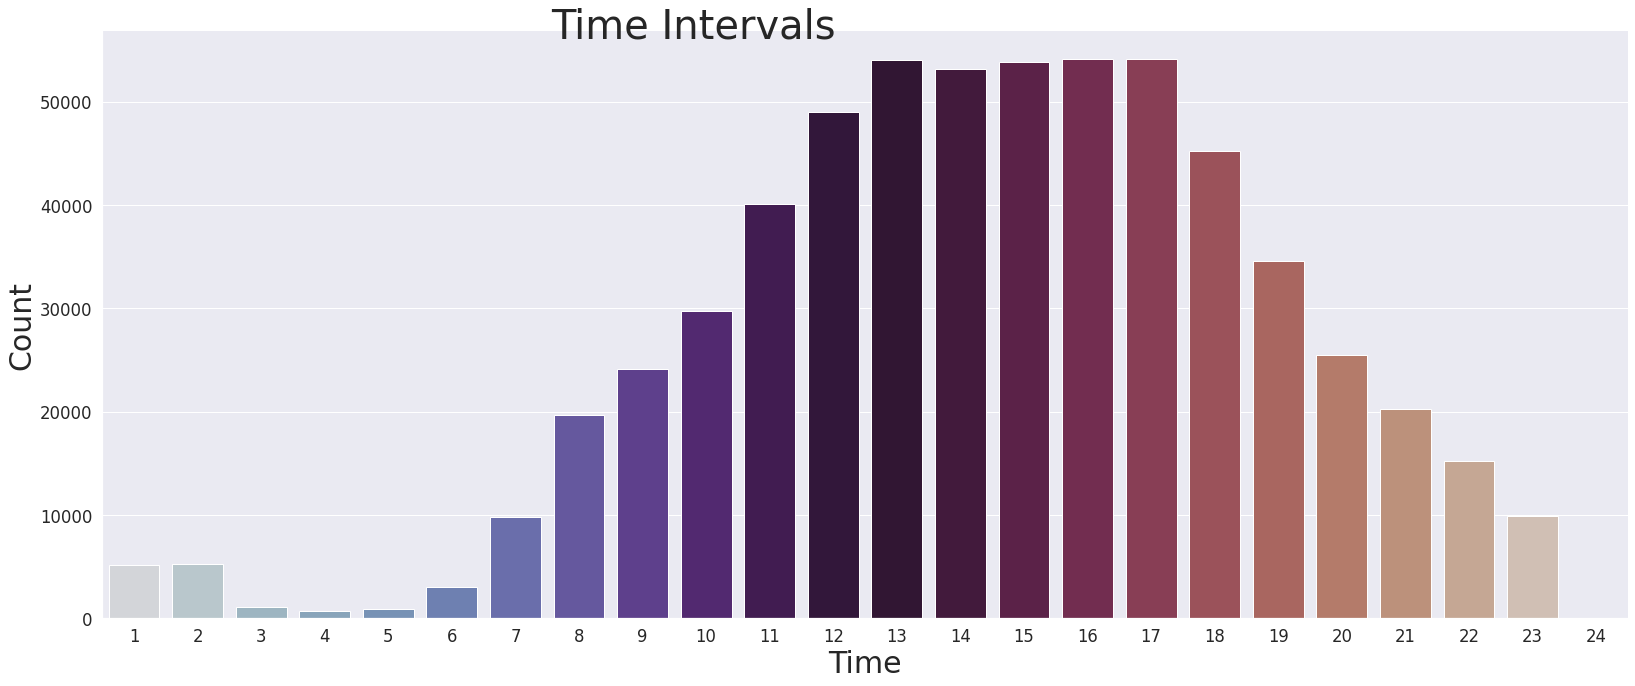

In [28]:
sns.set(font_scale = 1.5)
g=sns.catplot(x="start_hour",
              kind="count",
              palette="twilight",
              data = cbd,
              order = ["1","2","3","4","5","6","7","8","9","10",
                       "11","12","13","14","15","16","17","18",
                       "19","20","21","22","23","24"])

g.fig.set_size_inches(30,10)
g.fig.suptitle("Time Intervals", fontsize=40)
plt.ylabel("Count", fontsize = 30)
plt.xlabel("Time", fontsize = 30)

plt.show()

## Represent a technique that describes the area where most pickups occurred throughout the time.

In [29]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [30]:
# Create a map

m_2 = folium.Map(location=[30.2672,-97.7431], tiles='cartodbpositron', zoom_start=13)


# Add points to the map

for i in range(0,len(station_data)):
    Marker(location=[station_data.iloc[i]['latitude'], station_data.iloc[i]['longitude']],
        tooltip=(station_data.iloc[i]['name'],station_data.iloc[i]['status']),
        radius=20).add_to(m_2)

    
# Display the map

embed_map(m_2, 'm_2.html')

## Make the date predictions for the following 10 trips
First we will create a basic model to look at the Mean Absolute Error (MAE).

In [31]:
cbd["year"] = cbd["year"].astype('category')
cbd["month"] = cbd["month"].astype('category')
cbd["trip_id"] = cbd["trip_id"].astype('category')

cbd["date"] = cbd["date"].astype('int8')

cbd["year_code"] = cbd["year"].cat.codes
cbd["month_code"] = cbd["month"].cat.codes
cbd["trip_id_code"] = cbd["trip_id"].cat.codes

In [32]:
y = cbd.date

features = ['year_code','month_code','trip_id_code']

x = cbd[features]

In [33]:
# split X and y into training and testing sets

train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 0)

In [34]:
# building basic model for testing MAE

from sklearn.tree import DecisionTreeRegressor

basic_model = DecisionTreeRegressor()
basic_model.fit(train_x, train_y)
val_predictions = basic_model.predict(val_x)

print("Printing MAE for Basic Decision Tree Regressor: ", mean_absolute_error(val_y, val_predictions))

Printing MAE for Basic Decision Tree Regressor:  0.003592775467775468


Now we will be using the basic Decision Tree add more and more Leaf Nodes to try and focus the data.

In [35]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    leaf_model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    leaf_model.fit(train_x, train_y)
    preds_val = leaf_model.predict(val_x)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
print("Decision Tree with Leaves\n")
for max_leaf_nodes in [5, 50, 500, 5000,50000]:
    my_mae = get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y)
    
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %f" %(max_leaf_nodes, my_mae))

Decision Tree with Leaves

Max leaf nodes: 5  		 Mean Absolute Error:  7.036372
Max leaf nodes: 50  		 Mean Absolute Error:  4.982085
Max leaf nodes: 500  		 Mean Absolute Error:  0.533121
Max leaf nodes: 5000  		 Mean Absolute Error:  0.003983
Max leaf nodes: 50000  		 Mean Absolute Error:  0.003983


Now we will look at the Random Forest Regressor model.

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_x, train_y)
forest_preds = forest_model.predict(val_x)

print("Printing MAE for Random Forest Model: ",mean_absolute_error(val_y, forest_preds))

Printing MAE for Random Forest Model:  0.004493308212058213


In [37]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

perm = PermutationImportance(basic_model, random_state=1).fit(val_x, val_y)
eli5.show_weights(perm, feature_names = val_x.columns.tolist())

Weight,Feature
3.0870 ± 0.0111,trip_id_code
2.4656 ± 0.0030,month_code
0.1847 ± 0.0031,year_code


In [38]:
y = cbd.date

#choosing features
year_features = ['year_code','month_code','trip_id_code']
X = cbd[year_features]

#testing
#X.describe()
X.head()

,year_code,month_code,trip_id_code
0,2,2,348595
1,3,9,157741
2,3,2,30313
3,1,10,585011
4,4,3,236483


In [39]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X,y)

DecisionTreeRegressor(random_state=1)

In [40]:
print("Making date predictions for the following 10 trips:")
print(X.head(10))

print('\n')
print("The date predictions are")
print(model.predict(X.head(10)))

print('\nOriginal dates')
print(cbd['date'].head(10))

Making date predictions for the following 10 trips:
    year_code  month_code  trip_id_code
0           2           2        348595
1           3           9        157741
2           3           2         30313
3           1          10        585011
4           4           3        236483
5           2           4        419082
6           3           6        103481
7           2           0        271126
8           1           4        392630
10          1           2        317500


The date predictions are
[19. 30. 11. 23. 16. 29. 26. 15.  5. 14.]

Original dates
0     19
1     30
2     11
3     23
4     16
5     29
6     26
7     15
8      5
10    14
Name: date, dtype: int8


In [41]:
predicted_trip_month = model.predict(X)
print("Printing the mean absolute error", mean_absolute_error(y, predicted_trip_month))

Printing the mean absolute error 0.0


In [42]:
train_X, val_X, train_y, val_y = train_test_split(X,y, random_state = 0)

model = DecisionTreeRegressor()

model.fit(train_X,train_y)

#getting predicted points
val_predictions = model.predict(val_X)
print("Using the DecisionTreeRegressor.. Now\nPrinting the mean absolute value ",mean_absolute_error(val_y, val_predictions))

Using the DecisionTreeRegressor.. Now
Printing the mean absolute value  0.0035992723492723495


In [43]:
print("Making date predictions for the following 10 Trips:")
print(X.head(10))
print("The date predictions are")
print(model.predict(X.head(10)))

print('\nOriginal Dates')
print(cbd['date'].head(10))

Making date predictions for the following 10 Trips:
    year_code  month_code  trip_id_code
0           2           2        348595
1           3           9        157741
2           3           2         30313
3           1          10        585011
4           4           3        236483
5           2           4        419082
6           3           6        103481
7           2           0        271126
8           1           4        392630
10          1           2        317500
The date predictions are
[19. 30. 11. 23. 16. 29. 26. 15.  5. 14.]

Original Dates
0     19
1     30
2     11
3     23
4     16
5     29
6     26
7     15
8      5
10    14
Name: date, dtype: int8


## Using Cross-Validation

Cross-Validation is a way to get a more accurate measure of the model's quality. First we need to define a pipeline, which will fill in the missing values. A randomforest model will make the predictions.

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

In [45]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,random_state=0))])

In [46]:
points_CV = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring = 'neg_mean_absolute_error')
print("Using Cross Validation..\nNow Printing Mean Absolute Error points:\n", points_CV)

Using Cross Validation..
Now Printing Mean Absolute Error points:
 [0.00478804 0.0045574  0.00425659 0.00425806 0.00408219]


Cross validation used 5 different splits of the data to compute MAE. Now we will look at the whole model to be able to determine the model's quality and compare various models.

In [47]:
print("Using Cross Validation..\nNow Printing Average Mean Absolute Error points across all experiments: \n", points_CV.mean())

Using Cross Validation..
Now Printing Average Mean Absolute Error points across all experiments: 
 0.00438845517506857


## Using a Pipeline

In [48]:
import re
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [49]:
pipe_data = cbd

pipe_data.dropna(axis=0, inplace=True)
y = pipe_data.date

X_train_full, X_valid_full, y_train, y_valid = train_test_split(pipe_data, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10000 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])
 
# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE Using Pipeline:', mean_absolute_error(y_valid, preds))

MAE Using Pipeline: 7.137178853162003


## XGBRegressor

We will be working with extreme gradient boosting.

In [50]:
from xgboost import XGBRegressor

xgbr_model = XGBRegressor(n_estimators=5000, learning_rate=0.05, n_jobs=10)
xgbr_model.fit(train_X, train_y, 
             early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
predictionsXBGR = xgbr_model.predict(val_X)
print("Mean Absolute Error using XGBR: " + str(mean_absolute_error(predictionsXBGR, val_y)))

Mean Absolute Error using XGBR: 0.007992503


### Conclusion

- We find Riverside @ S.Lamar is the highest pick up point and City Hall/Lavaca & 2nd is the top drop off point.

- At the output cell [27] and cell [28] we can see our objective the busiest time period (days of the month, time intervals) when bikers shared more bikes.

- And then we used Geospatial mapping technique that describes the area where most pickups occurred throughout the time.

- In the end we made the date predictions for the following 10 trips and verified model MAE with Cross-Validation, Pipeline and XGBoost Regression.